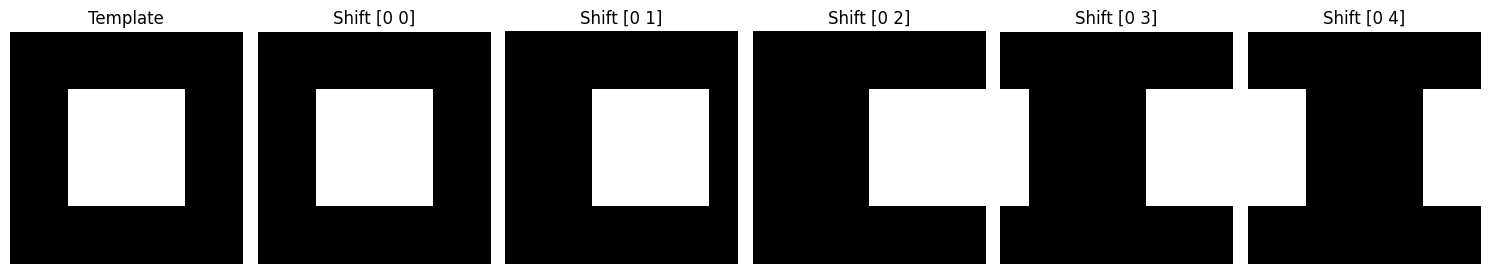

[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]
 [0 6]
 [0 7]
 [1 0]
 [1 1]
 [1 2]
 [1 3]
 [1 4]
 [1 5]
 [1 6]
 [1 7]
 [2 0]
 [2 1]
 [2 2]
 [2 3]
 [2 4]
 [2 5]
 [2 6]
 [2 7]
 [3 0]
 [3 1]
 [3 2]
 [3 3]
 [3 4]
 [3 5]
 [3 6]
 [3 7]
 [4 0]
 [4 1]
 [4 2]
 [4 3]
 [4 4]
 [4 5]
 [4 6]
 [4 7]
 [5 0]
 [5 1]
 [5 2]
 [5 3]
 [5 4]
 [5 5]
 [5 6]
 [5 7]
 [6 0]
 [6 1]
 [6 2]
 [6 3]
 [6 4]
 [6 5]
 [6 6]
 [6 7]
 [7 0]
 [7 1]
 [7 2]
 [7 3]
 [7 4]
 [7 5]
 [7 6]
 [7 7]]


In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Generate template image and dataset
image_size = 8  # Size of image
template = np.zeros((image_size, image_size))
template[image_size//4:3*image_size//4, image_size//4:3*image_size//4] = 1  # Create a box in the middle

# Generate dataset by rolling in 2D
arrays = []
shifts = []
for x in range(image_size):
    for y in range(image_size):
        shifted = np.roll(np.roll(template, x, axis=0), y, axis=1)
        arrays.append(shifted)
        shifts.append((x, y))
arrays = np.array(arrays)
shifts = np.array(shifts)

# Plot template and some rolled versions
plt.figure(figsize=(15, 3))
plt.subplot(1, 6, 1)
plt.imshow(template, cmap='gray')
plt.title('Template')
plt.axis('off')
for i in range(5):
    plt.subplot(1, 6, i+2)
    plt.imshow(arrays[i], cmap='gray')
    plt.title(f'Shift {shifts[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

print(shifts)


In [5]:
# Create neural network
class AdditionImages(nn.Module):
    def __init__(self, image_size, alpha=1e-4):
        super().__init__()
        # Take 2 images as input (2*image_size*image_size) and output 1 image (image_size*image_size)
        self.fc1_u_v = nn.Linear(2*image_size*image_size, image_size*image_size)
        self.fc2_w = nn.Linear(image_size*image_size, image_size*image_size)
        self.image_size = image_size
        self.alpha = alpha
        
    def forward(self, x):
        x = self.fc1_u_v(x)
        x = x * x  # Quadratic nonlinearity
        x = self.fc2_w(x)
        # Reshape output back to image dimensions
        return self.alpha * x.view(-1, self.image_size, self.image_size)

# Create custom dataset
class ImageShiftDataset(Dataset):
    def __init__(self, images, shifts):
        self.images = torch.FloatTensor(images)
        self.shifts = torch.LongTensor(shifts)
        print(images.shape)
        _, image_size, _ = images.shape  # Assuming square images
        
        # For all pairs of images
        self.x = torch.zeros((len(self.images) * len(self.images), 2 * image_size * image_size))
        self.y = torch.zeros((len(self.images) * len(self.images), image_size, image_size))
        
        for i in range(len(self.images)):
            for j in range(len(self.images)):
                # Flatten and concatenate the two input images
                self.x[i * len(self.images) + j] = torch.cat([
                    self.images[i].flatten(),
                    self.images[j].flatten()
                ])
                
                # Sum the shifts and get corresponding output image
                combined_shift = (shifts[i] + shifts[j]) % image_size
                combined_shift = combined_shift[0] * image_size + combined_shift[1]
                self.y[i * len(self.images) + j] = self.images[combined_shift]
        
    def __len__(self):
        # all possible combinations of two images
        return len(self.images) * len(self.images)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Create dataset and dataloader
dataset = ImageShiftDataset(arrays, shifts)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)


(64, 8, 8)


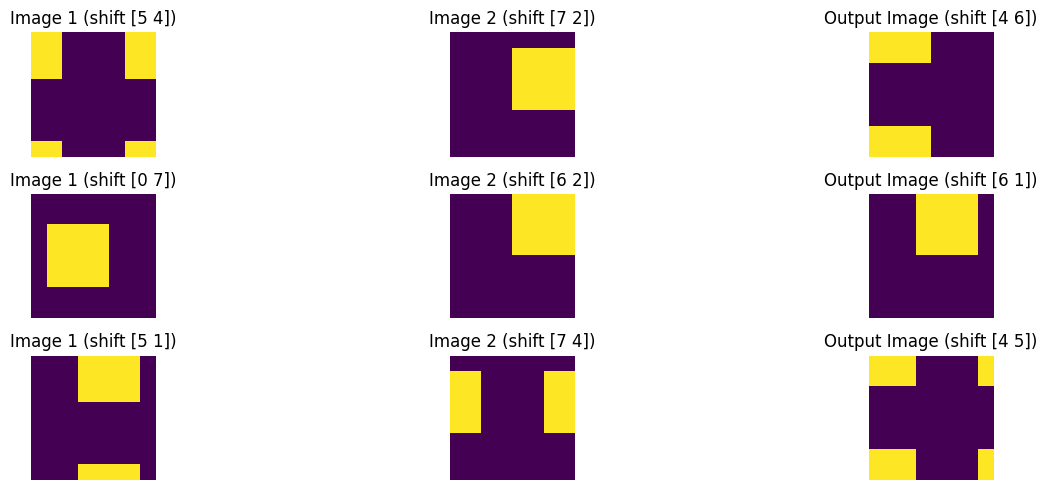

In [6]:
# Plot a few examples from the dataset to check that the dataset is correct
plt.figure(figsize=(15,5))
for i in range(3):
    # Get a random sample from dataset
    idx = np.random.randint(len(dataset))
    x, y = dataset[idx]
    
    # Split the data back into the two original images
    array1 = x[:image_size*image_size].reshape(image_size, image_size)
    array2 = x[image_size*image_size:].reshape(image_size, image_size)
    array3 = y
    
    # Find the original indices and shifts
    # Possible to get the indices from the dataset because the dataset is not shuffled
    idx1 = idx // len(arrays)
    idx2 = idx % len(arrays)
    shift1 = shifts[idx1]
    shift2 = shifts[idx2]
    
    # Plot on the current row
    plt.subplot(3, 3, i*3 + 1)
    plt.imshow(array1)
    plt.title(f'Image 1 (shift {shift1})')
    plt.axis('off')
    
    plt.subplot(3, 3, i*3 + 2)
    plt.imshow(array2)
    plt.title(f'Image 2 (shift {shift2})')
    plt.axis('off')
    
    plt.subplot(3, 3, i*3 + 3)
    plt.imshow(array3)
    plt.title(f'Output Image (shift {(shift1 + shift2) % image_size})')
    plt.axis('off')
    
    # No need to plot expected image separately since y already contains
    # the correct shifted and combined image

plt.tight_layout()
plt.show()


Epoch 100/1000, Loss: 0.134258


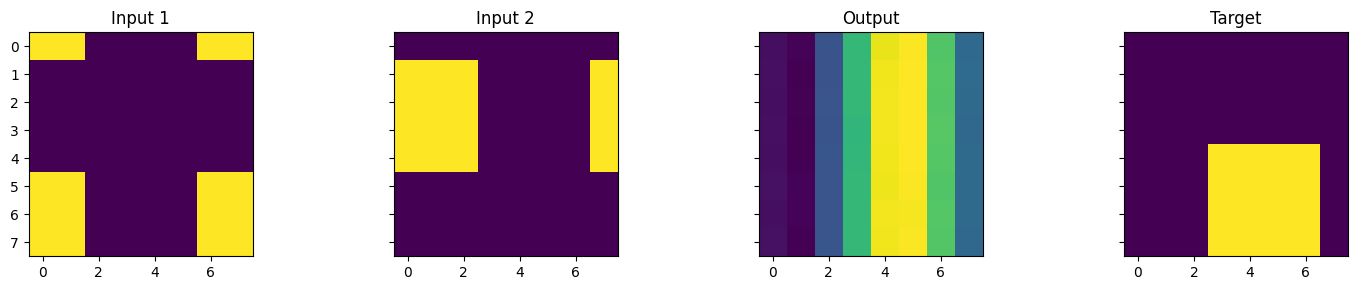

Epoch 200/1000, Loss: 0.058110


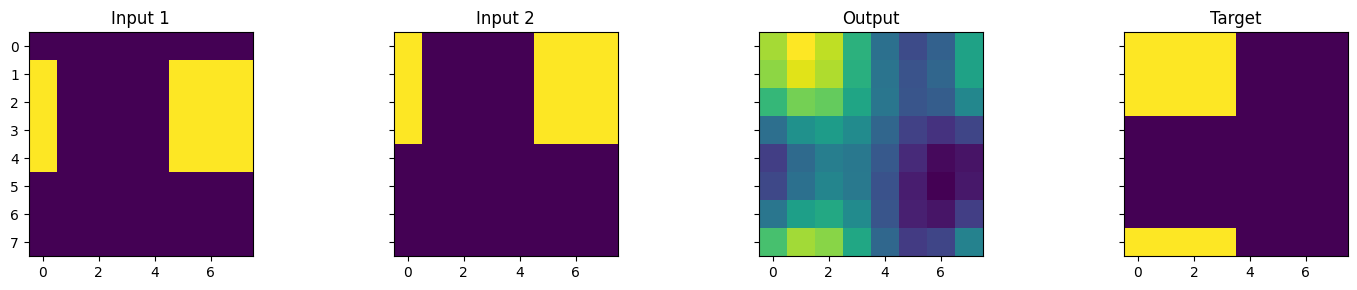

Epoch 300/1000, Loss: 0.035379


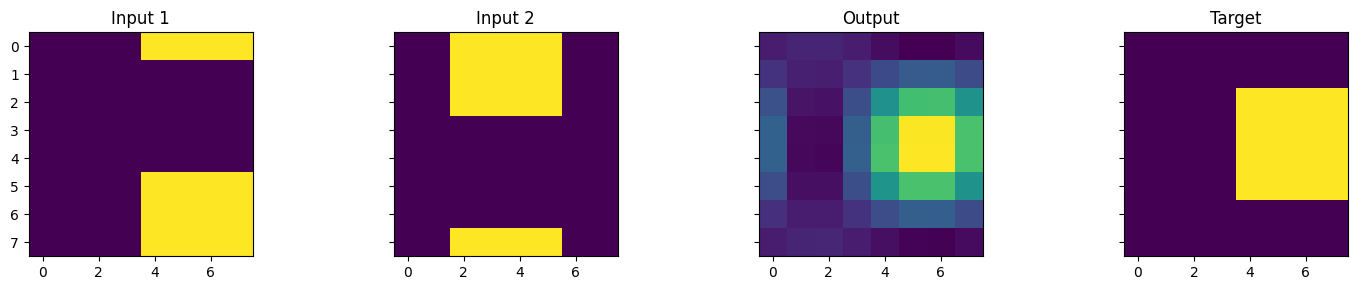

Epoch 400/1000, Loss: 0.029118


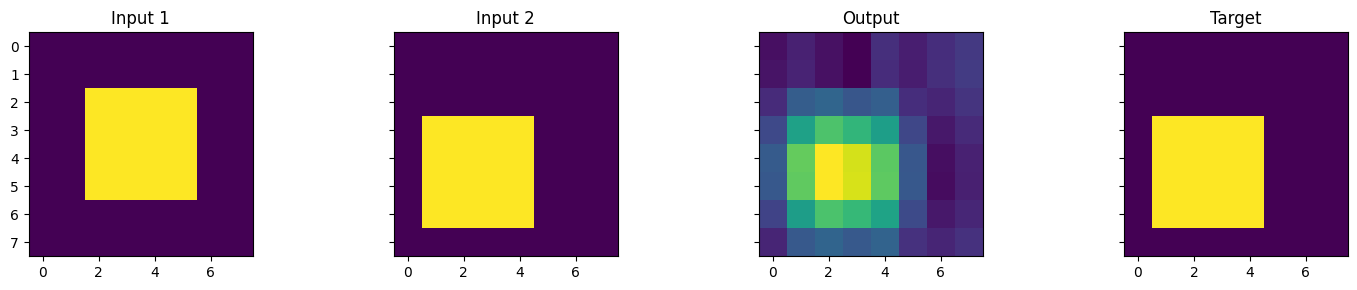

Epoch 500/1000, Loss: 0.023484


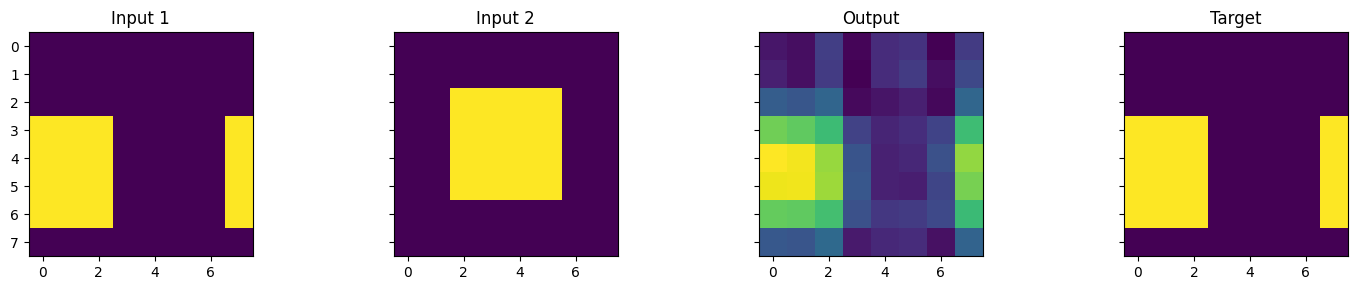

Epoch 600/1000, Loss: 0.020534


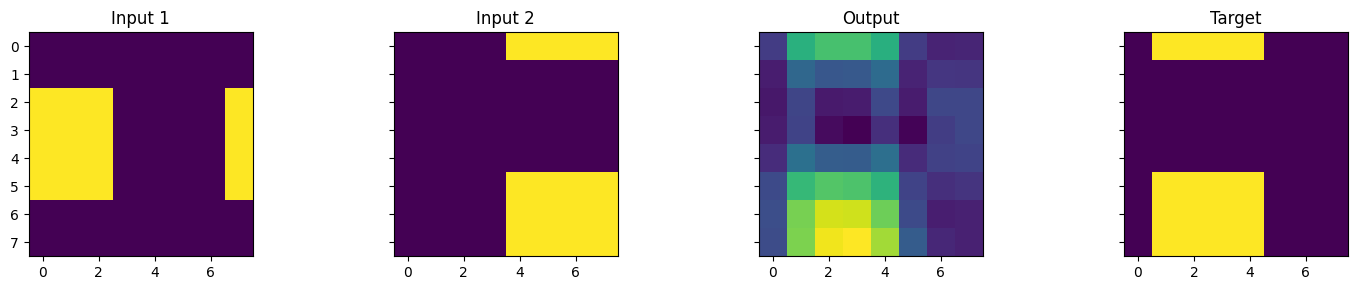

Epoch 700/1000, Loss: 0.016107


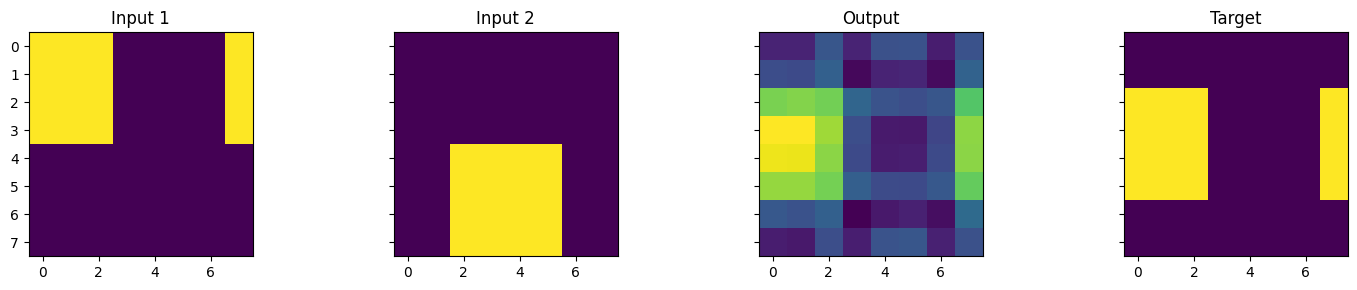

Epoch 800/1000, Loss: 0.016100


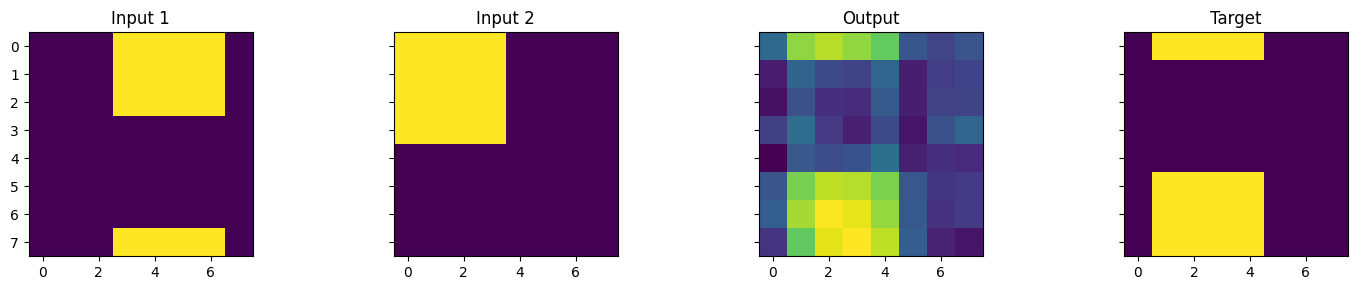

Epoch 900/1000, Loss: 0.015289


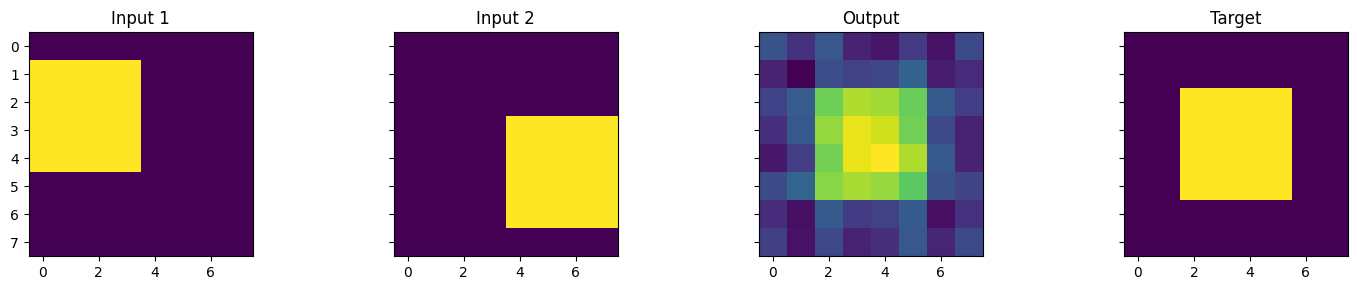

Epoch 1000/1000, Loss: 0.013389


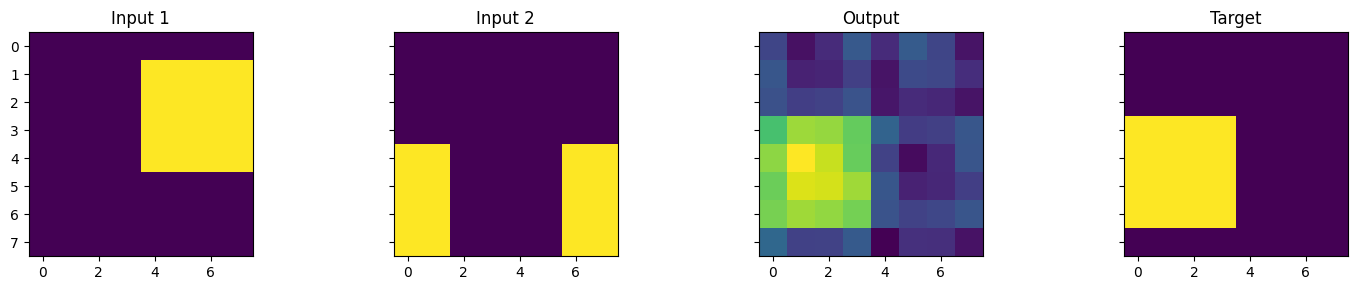

In [7]:
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AdditionImages(image_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Training loop
n_epochs = 1000
losses = []
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)  # Add this line to store the average loss

    # Plot results
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.6f}')
        model.eval()
        with torch.no_grad():
            # Get one random example
            idx = np.random.randint(len(dataset))
            x, y = dataset[idx]
            output = model(x.cuda()).cpu().numpy()
            target = y.cpu().numpy()
            
            fig, _ = plt.subplots(1, 4, figsize=(15, 3), sharey=True)
            plt.subplot(141)
            plt.imshow(x[:image_size*image_size].reshape(image_size, image_size))
            plt.title(f'Input 1')
            plt.subplot(142)
            plt.imshow(x[image_size*image_size:].reshape(image_size, image_size))
            plt.title(f'Input 2')
            plt.subplot(143)
            plt.imshow(output[0])
            plt.title('Output')
            plt.subplot(144)
            plt.imshow(target)
            plt.title('Target')
            plt.tight_layout()
            plt.show()

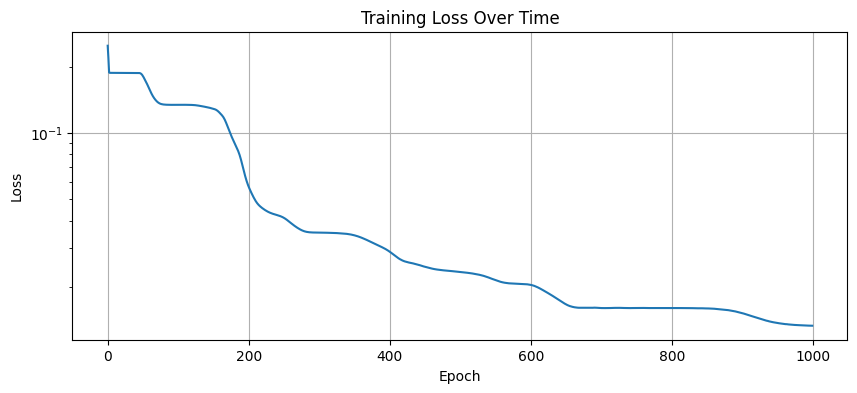

In [8]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')  # Using log scale since loss typically decreases exponentially
plt.grid(True)
plt.show()

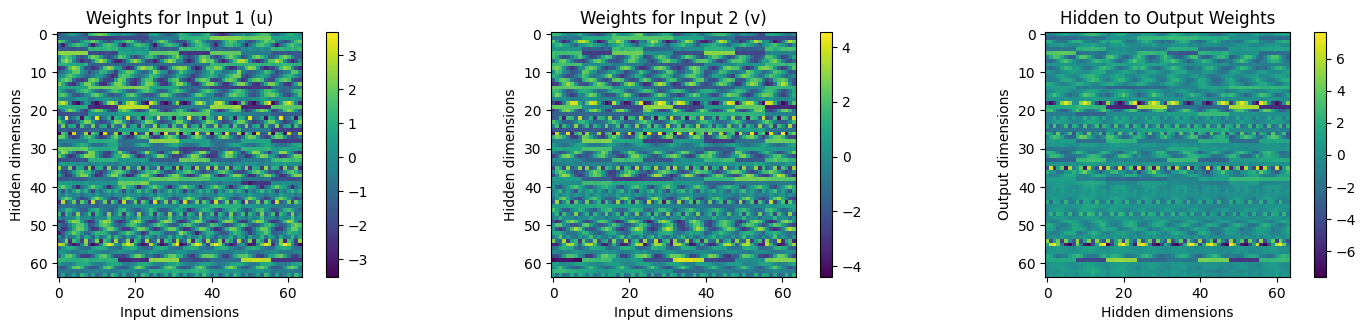

In [9]:
# Get the model weights
weights = []
for name, param in model.named_parameters():
    if 'weight' in name:
        weights.append(param.detach().cpu().numpy())

# Create figure with subplots for heatmaps
plt.figure(figsize=(15, 6))

# Plot weights for first input array - heatmap
plt.subplot(231)
plt.imshow(weights[0][:,:image_size*image_size], cmap='viridis')
plt.colorbar()
plt.title('Weights for Input 1 (u)')
plt.xlabel('Input dimensions')
plt.ylabel('Hidden dimensions')

# Plot weights for second input array - heatmap
plt.subplot(232)
plt.imshow(weights[0][:,image_size*image_size:], cmap='viridis')
plt.colorbar()
plt.title('Weights for Input 2 (v)')
plt.xlabel('Input dimensions')
plt.ylabel('Hidden dimensions')

# Plot weights from hidden to output - heatmap
plt.subplot(233)
plt.imshow(weights[1].T, cmap='viridis')
plt.colorbar()
plt.title('Hidden to Output Weights')
plt.xlabel('Hidden dimensions')
plt.ylabel('Output dimensions')

plt.tight_layout()


In [10]:
arrays.shape

(64, 8, 8)

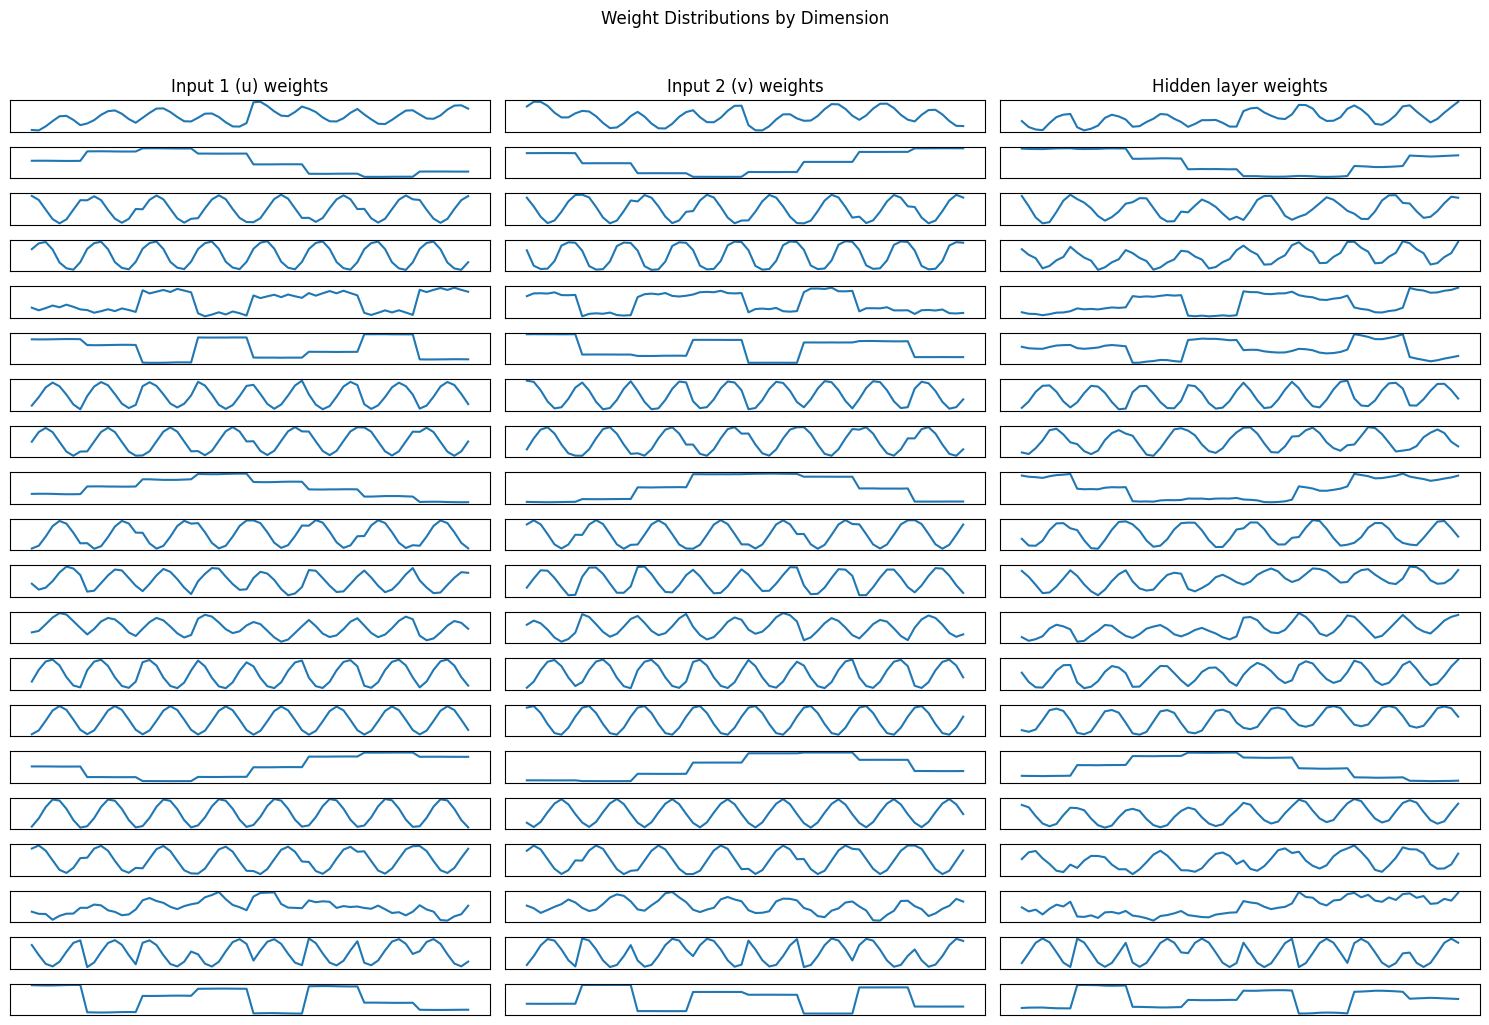

In [11]:
# Create figure with subplots for line plots
fig, axes = plt.subplots(20, 3, figsize=(15, 10))
fig.suptitle('Weight Distributions by Dimension', y=1.02)

# Plot each dimension as a line plot
for i in range(20):
    # Plot weights for first input array
    axes[i,0].plot(arrays.reshape(len(arrays), -1) @ weights[0][i,:image_size*image_size])
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    
    # Plot weights for second input array
    axes[i,1].plot(arrays.reshape(len(arrays), -1) @ weights[0][i,image_size*image_size:])
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])
    
    # Plot weights from hidden to output
    axes[i,2].plot(arrays.reshape(len(arrays), -1) @ weights[1][:,i])
    axes[i,2].set_xticks([])
    axes[i,2].set_yticks([])

# Add column labels at the top
axes[0,0].set_title('Input 1 (u) weights')
axes[0,1].set_title('Input 2 (v) weights') 
axes[0,2].set_title('Hidden layer weights')

plt.tight_layout()
plt.show()

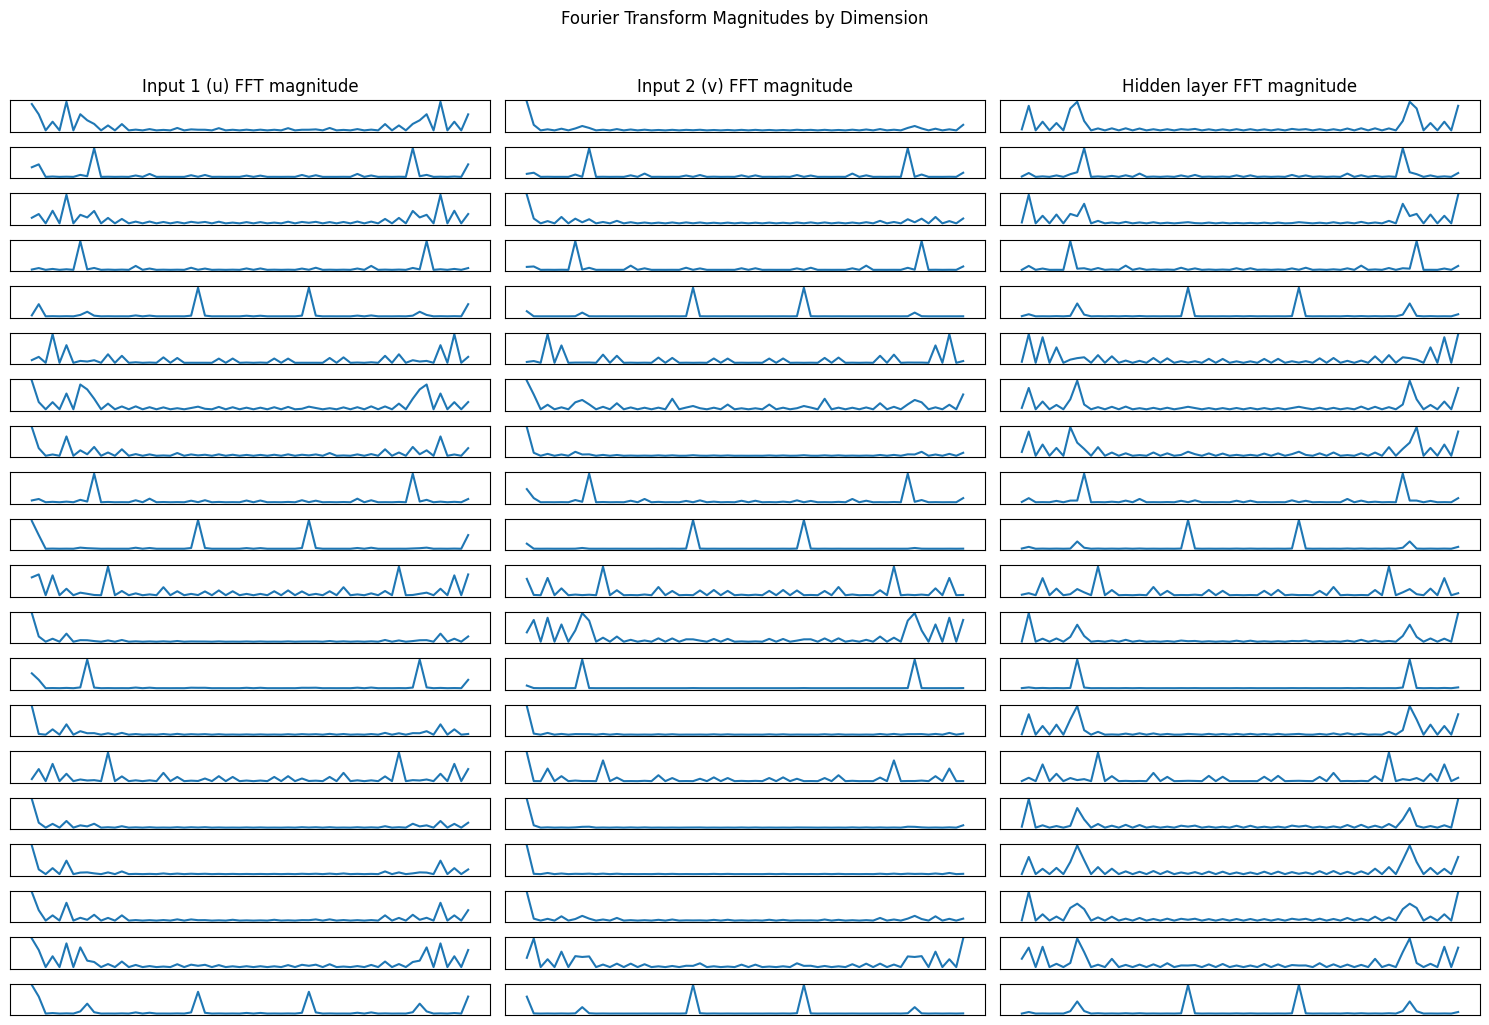

In [13]:
# Create figure with subplots for FFT magnitude plots
fig, axes = plt.subplots(20, 3, figsize=(15, 10))
fig.suptitle('Fourier Transform Magnitudes by Dimension', y=1.02)

# Plot FFT magnitude for each dimension
for i in range(20):
    # FFT for first input array weights
    fft_u = np.abs(np.fft.fft(arrays.reshape(len(arrays), -1) @ weights[0][i,:image_size*image_size]))
    axes[i,0].plot(fft_u)
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    
    # FFT for second input array weights
    fft_v = np.abs(np.fft.fft(arrays.reshape(len(arrays), -1) @ weights[0][i,image_size*image_size:]))
    axes[i,1].plot(fft_v)
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])
    
    # FFT for hidden to output weights
    fft_h = np.abs(np.fft.fft(arrays.reshape(len(arrays), -1) @ weights[1][:,i]))
    axes[i,2].plot(fft_h)
    axes[i,2].set_xticks([])
    axes[i,2].set_yticks([])

# Add column labels at the top
axes[0,0].set_title('Input 1 (u) FFT magnitude')
axes[0,1].set_title('Input 2 (v) FFT magnitude')
axes[0,2].set_title('Hidden layer FFT magnitude')

plt.tight_layout()
plt.show()
